

<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## PGE 383 Graduate Student Project _ Mohamed Mohamed _ EID: mm94684




## Simple Demonstration K-nearest Neighbour and Random Forest Regression  Application and Limitations

#### Mohamed Mohamed 
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Misael Morales, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/misaelmmorales/)


### Executive Summary

In this project, I will compare two methods: K-nearest neighbor and RandomForest regression. I want to demonstrate the limitation of each method using large and complicated data set. I will use the notebook with the different methods to find the correlation between reservoir parameters and the original reserves for fields in Gulf of Mexico. 

#### Goals

* Learn the basics of k-Nearest Neighbour and Random Forest Regression 
* Visualizing sample and predicted data 
* Demonstrate the advantages of both methods 
* Compare the limitations of each method 
* Capability of both methods to deal with large and complicated data sets

In [169]:
import numpy as np                                      
import pandas as pd                                     
import os                                               
import matplotlib.pyplot as plt 
import pandas.plotting as pd_plot
from scipy import stats                                 
import math        
import cmath
import scipy.signal as signal                           
import random                                           
import seaborn as sns                                   
from scipy import linalg                                
from subprocess import check_call
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.model_selection import train_test_split
import geostatspy.GSLIB as GSLIB                        
import geostatspy.geostats as geostats                  

### Loading the Data

Below I will set the working directory then load the datta 

In [2]:
os.chdir("C:\\Mohamed\\PGE383_ML\\Final_Project")
my_data = pd.read_csv("Project_data_final_2.csv")
response = 'Orig_RES_G'

###  Data Preparation and Feature Ranking 

Data preparation was performed using Dr. Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_Feature_Ranking.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics__Feature_Ranking.ipynb). Features with high percentage of missing data (example Permeability) were excluded. The top two predictor features are Total Vertical Stress (Sig_v) and Pressure (PI). the respone feature is Original Gas Reserves (Orig_RES_G)
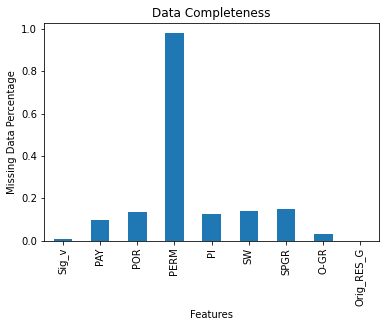

In [3]:
my_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Sig_v,1094.0,9550.607781,2873.151171,1151.0,7431.250000,9341.500000,11502.250000,18000.0
PI,1094.0,4247.901755,2555.667529,0.0,2924.500000,4114.250000,5516.250000,14494.0
Orig_RES_G,1094.0,57.012480,228.716026,0.0,0.133603,3.183122,22.173163,3692.2


#### Data Range and Standardizing Predictor Features

First, setting the range of each feature for better visualization and to avoid arbitrary feature weighting. 

Then, Standardizing the predictore features to a mean of zero and variance of 1, to elemenate the effect of different features scale and feature range. 


In [5]:
transform = StandardScaler();
sig_vmin = 1150; sig_vmax = 18000     
pimin = 100.0; pimax = 15000.0
orig_res_gmin = 0.0; orig_res_gmax = 3700.0

features = ['Sig_v', 'PI']
my_data['sSig_v'] = transform.fit_transform(my_data.loc[:,features].values)[:,0] 
my_data['sPI'] = transform.fit_transform(my_data.loc[:,features].values)[:,1] 


#### Training and Testing Data

Randomly splitting data into traning and testing sets. 75% of the data were used for training the model and 25% were used for testing and tuning the model

Training data will be used to train themodel parameters, however we should be careful not to overfit the model. While testing data will be used to tune the model hyperparameters.

The following two code blocks is from Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_kNearestNeighbour.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_kNearestNeighbour.ipynb).



In [102]:
X_train, X_test, y_train, y_test = train_test_split(my_data.iloc[:,[0,1]], my_data.iloc[:,2], test_size=0.25)
X_train['sSig_v'] = transform.fit_transform(X_train.loc[:,features].values)[:,0] 
X_train['sPI'] = transform.fit_transform(X_train.loc[:,features].values)[:,1] 
X_test['sSig_v'] = transform.fit_transform(X_test.loc[:,features].values)[:,0] 
X_test['sPI'] = transform.fit_transform(X_test.loc[:,features].values)[:,1] 

y_train = pd.DataFrame({'Orig_RES_G':y_train.values})
y_test = pd.DataFrame({'Orig_RES_G':y_test.values})

y_train['tOrig_RES_G'] = np.where(y_train['Orig_RES_G']>=50, 'High', 'Low') # make a high and low production categorical feature
y_test['tOrig_RES_G'] = np.where(y_test['Orig_RES_G']>=50, 'High', 'Low') # make a high and low production categorical feature
my_data['tOrig_RES_G'] = np.where(my_data['Orig_RES_G']>=50, 'High', 'Low') # make a high and low production categorical feature

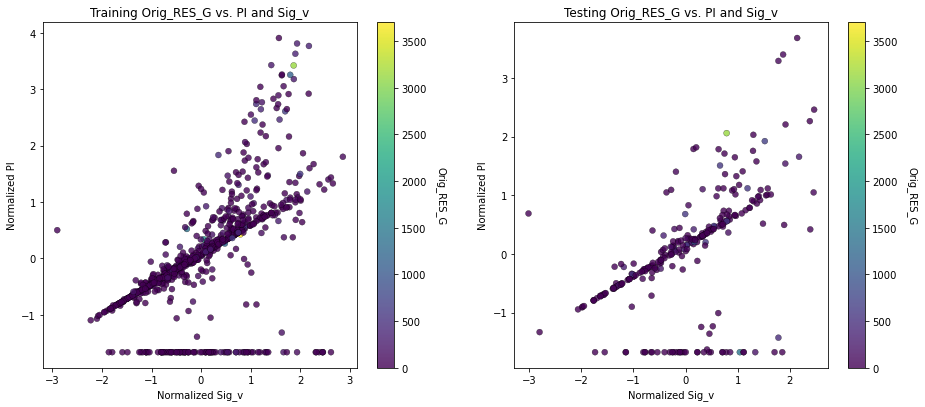

In [21]:
plt.subplot(121)
im = plt.scatter(X_train["sSig_v"],X_train["sPI"],s=None, c=y_train['Orig_RES_G'], marker=None, cmap=None, norm=None, vmin=orig_res_gmin, vmax=orig_res_gmax, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Training Orig_RES_G vs. PI and Sig_v'); plt.xlabel('Normalized Sig_v'); plt.ylabel('Normalized PI')
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label("Orig_RES_G", rotation=270, labelpad=20)

plt.subplot(122)
im = plt.scatter(X_test["sSig_v"],X_test["sPI"],s=None, c=y_test['Orig_RES_G'], marker=None, cmap=None, norm=None, vmin=orig_res_gmin, vmax=orig_res_gmax, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Testing Orig_RES_G vs. PI and Sig_v'); plt.xlabel('Normalized Sig_v'); plt.ylabel('Normalized PI')
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label("Orig_RES_G", rotation=270, labelpad=20)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

#### K-Nearest Neighbours

it can be used for both classification and regression. It is supervised learning and non-parametric method. The algorithm predicts the new data points values using similarity in feature space. The algorithm assigns a value for the new point based on the distance with the training set points.

**Hyperparameters**

* **$k$ number of nearest data** to utilize for prediction

* **data weighting**, for example uniform weighting (use local training data average), inverse distance weighting
(from Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_kNearestNeighbour.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_kNearestNeighbour.ipynb).)

Steps of K-Nearest Neighbours steps:
1. calcualte the distance between the new point and each training point
2. Select the closest k data points
3. Moving window average is used to predict the new point.

Advantages of k-nearest neighbors algorithm:
1. Can be used for both regression and classification
2. can be used with non-linear data
3. Easy to understand and simple to use 
4. can work with smaller data sets comparing to other methods 
5. Can work with multi-class cases
6. Instance-based, lazy learning

Disadvantages of k-nearest neighbors algorithm:
1. High memory storage 
2. High computation cost
3. Slow prediction with high number of points
4. Optimum value of K is required
5. Sensitive to irrelevant features

The K-nearest neighbour below code blocks (with some modification) are from Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_kNearestNeighbour.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_kNearestNeighbour.ipynb).



In [280]:
neigh = KNeighborsRegressor(weights = 'uniform', n_neighbors=70, p = 2) # instantiate the prediction model

Now we will fit our model for prediction, by using our predictor functions to visualizze $k$ nearest neighbour prediction over the feature space

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


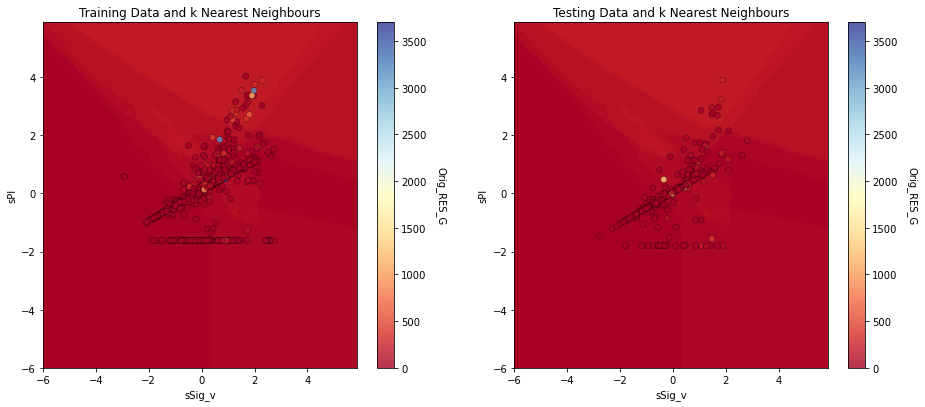

In [281]:
def visualize_model(model,xfeature,x_min,x_max,yfeature,y_min,y_max,response,z_min,z_max,title,):# plots the data points and the decision tree prediction 
    n_classes = 1
    cmap = plt.cm.RdYlBu
    xplot_step = (x_max-x_min)/100; yplot_step = (y_max-y_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, xplot_step),
                     np.arange(y_min, y_max, yplot_step))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap,vmin=z_min, vmax=z_max, levels=np.linspace(z_min, z_max, 100))

    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, edgecolors="black")
    plt.title(title)
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(response.name, rotation=270, labelpad=20)
#
neigh_fit = neigh.fit(X_train[['sSig_v','sPI']],y_train['Orig_RES_G'])              # train the model with the training data

plt.subplot(121)
visualize_model(neigh_fit,X_train["sSig_v"],-6,6,X_train["sPI"],-6,6,y_train["Orig_RES_G"],orig_res_gmin,orig_res_gmax,'Training Data and k Nearest Neighbours')

plt.subplot(122)
visualize_model(neigh_fit,X_test["sSig_v"],-6,6,X_test["sPI"],-6,6,y_test["Orig_RES_G"],orig_res_gmin,orig_res_gmax,'Testing Data and k Nearest Neighbours')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

after fitting the model with the training data , the next step is tuning the hyperparameters by  looping over multiple $k$ nearest neighbours for average and inverse distance estimates with respect to accuracy in testing

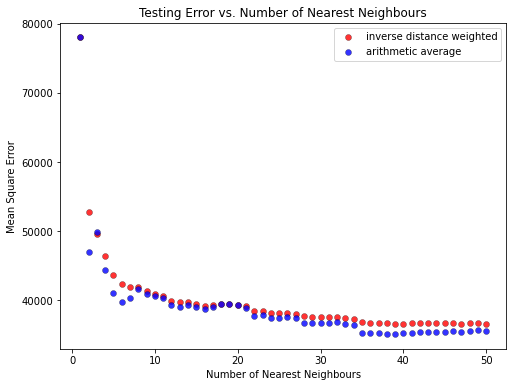

In [282]:
k = 1
dist_error = []
unif_error = []
k_mat = np.linspace(1,50,50)
while k <= 50:
    neigh_dist = KNeighborsRegressor(weights = 'distance', n_neighbors=k, p = 1)
    neigh_dist_fit = neigh_dist.fit(X_train,y_train['Orig_RES_G'])    # train the model with the training data
    y_pred = neigh_dist_fit.predict(X_test)
    MSE = metrics.mean_squared_error(y_test['Orig_RES_G'],y_pred)
    dist_error.append(MSE)
    
    neigh_unif = KNeighborsRegressor(weights = 'uniform', n_neighbors=k, p = 1)
    neigh_unif_fit = neigh_unif.fit(X_train,y_train['Orig_RES_G'])    # train the model with the training data
    y_pred = neigh_unif_fit.predict(X_test)
    MSE = metrics.mean_squared_error(y_test['Orig_RES_G'],y_pred)
    unif_error.append(MSE)
    k = k + 1
    
plt.figure(figsize=(8,6))
plt.scatter(k_mat,dist_error,s=None, c='red',label = 'inverse distance weighted', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.scatter(k_mat,unif_error,s=None, c='blue',label = 'arithmetic average', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Testing Error vs. Number of Nearest Neighbours'); plt.xlabel('Number of Nearest Neighbours'); plt.ylabel('Mean Square Error')
plt.legend()
plt.show()

#### k-fold Cross Validation

Evaluating the performance of the model by observing the accuracy vs. complexity trade-off.   


In [283]:
score = []                                                  # code modified from StackOverFlow by Dimosthenis
k_mat = []
for k in range(0,50):
    neigh_dist = KNeighborsRegressor(weights = 'distance', n_neighbors=k, p = 1)
    scores = cross_val_score(estimator=neigh_dist, X= np.c_[my_data['sSig_v'],my_data['sPI']],y=my_data['Orig_RES_G'], cv=4, n_jobs=4,scoring = "neg_mean_squared_error") # Perform 7-fold cross validation
    score.append(abs(scores.mean()))
    k_mat.append(k)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
4 fits failed out of a total of 4.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_regression.py", line 213, in fit
    return self._fit(X, y)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 569, in _fit
    raise ValueError("Expected n_neighbors > 0. Got %d" % self.n_neighbors)
ValueErro

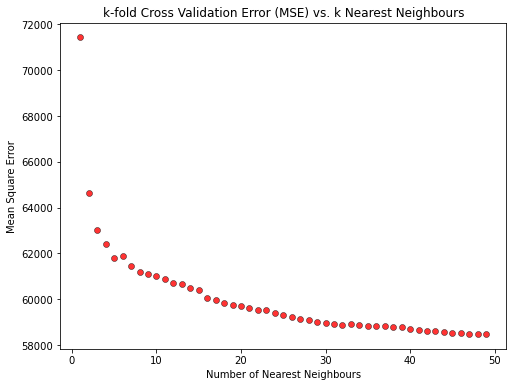

In [284]:
plt.figure(figsize=(8,6))
plt.scatter(k_mat,score,s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.5, edgecolors="black")
plt.title('k-fold Cross Validation Error (MSE) vs. k Nearest Neighbours'); plt.xlabel('Number of Nearest Neighbours'); plt.ylabel('Mean Square Error')
plt.show()

The final model after tuning the hyperparameters 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


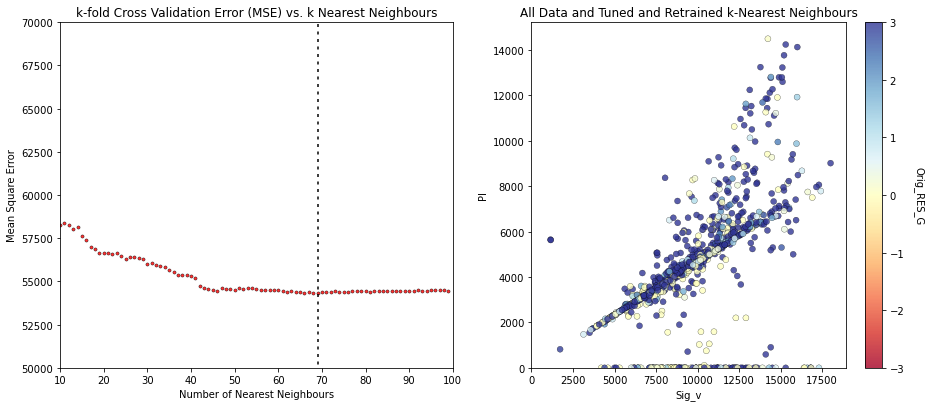

In [285]:
from sklearn.pipeline import Pipeline                       # machine learning modeling pipeline
from sklearn.pipeline import make_pipeline                  # machine learning modeling pipeline
from sklearn.model_selection import GridSearchCV            # model hyperparameter grid search
from sklearn.model_selection import KFold                   # k-fold cross validation

def visualize_tuned_model(k_tuned,k_mat,score_mat):
    plt.scatter(k_mat,score_mat,s=10.0, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.5, edgecolors="black")
    plt.plot([k_tuned,k_tuned],[0,10000000],color='black',linestyle=(6, (2,3)),label='tuned',zorder=1)
    plt.title('k-fold Cross Validation Error (MSE) vs. k Nearest Neighbours'); plt.xlabel('Number of Nearest Neighbours'); plt.ylabel('Mean Square Error')
    plt.xlim(k_min,k_max); plt.ylim(50000,70000)#(0,np.max(score_mat))
    

folds = 5                                                   # number of k folds
k_min = 10; k_max = 100                                       # range of k hyperparameter to consider

X = my_data.loc[:,["Sig_v","PI"]]                        # all the samples for the original features
y = my_data.loc[:,"Orig_RES_G"]                             # warning this becomes a series, 1D ndarray with label

pipe = Pipeline([                                           # the machine learning workflow as a pipeline object
    ('scaler', StandardScaler()),
    ('knear', KNeighborsRegressor())
])

params = {                                                  # the machine learning workflow method's parameters
    'scaler': [StandardScaler()],
    'knear__n_neighbors': np.arange(k_min,k_max,1,dtype = int),
    'knear__metric': ['euclidean'],
    'knear__p': [68],
    'knear__weights': ['uniform']
}

grid_cv_tuned = GridSearchCV(pipe, params, scoring = 'neg_mean_squared_error', # grid search cross validation 
                             cv=KFold(n_splits=folds,shuffle=False),
                             refit = True)
grid_cv_tuned.fit(X,y)                                      # fit model with tuned hyperparameters

plt.subplot(121)
visualize_tuned_model(grid_cv_tuned.best_params_['knear__n_neighbors'], # visualize the error vs. k 
                      grid_cv_tuned.cv_results_['param_knear__n_neighbors'],
                      abs(grid_cv_tuned.cv_results_['mean_test_score']))              

plt.subplot(122)                                            # visualize the tuned model
visualize_model(grid_cv_tuned,X["Sig_v"],-5,5,X["PI"],-3,3,my_data["Orig_RES_G"],-3,3,'All Data and Tuned and Retrained k-Nearest Neighbours')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2);
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


Mean Squared Error on Training =  54868.27 , Variance Explained = 0.05
Mean Squared Error on Training =  36204.3 , Variance Explained = -0.01


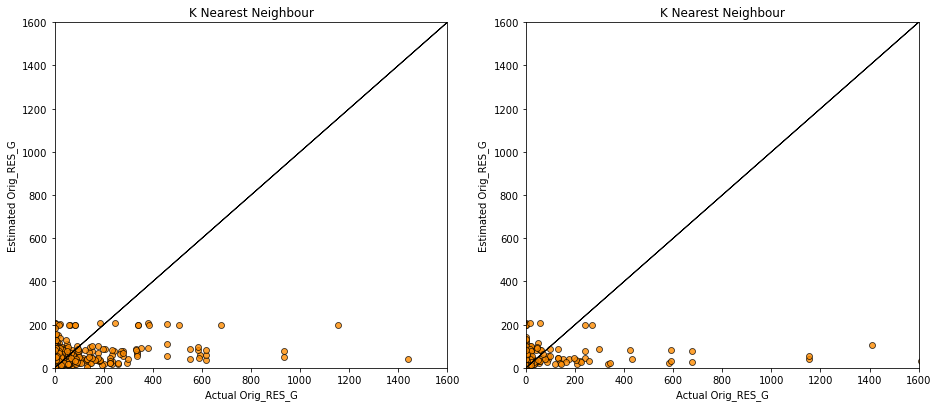

In [286]:
#code block from Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_kNearestNeighbour.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_kNearestNeighbour.ipynb).
def check_model(model,xfeature,yfeature,response,title):    # plots the estimated vs. the actual  
    predict_train = model.predict(np.c_[xfeature,yfeature])
    plt.scatter(response,predict_train,s=None, c='darkorange',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.8, edgecolors="black")
    plt.title(title); plt.xlabel('Actual Orig_RES_G'); plt.ylabel('Estimated Orig_RES_G')
    plt.xlim(0,1600); plt.ylim(0,1600)
    plt.arrow(0,0,1600,1600,width=0.02,color='black',head_length=0.0,head_width=0.0)
    MSE = metrics.mean_squared_error(response,predict_train)
    Var_Explained = metrics.explained_variance_score(response,predict_train)
    cor = cmath.sqrt(metrics.r2_score(response,predict_train))
    print('Mean Squared Error on Training = ', round(MSE,2),', Variance Explained =', round(Var_Explained,2))

plt.subplot(121)
check_model(neigh_fit,X_train["sSig_v"],X_train["sPI"],y_train["Orig_RES_G"],'K Nearest Neighbour')

plt.subplot(122)
check_model(neigh_fit,X_test["sSig_v"],X_test["sPI"],y_test["Orig_RES_G"],'K Nearest Neighbour')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2);
plt.show()

#### Random Forest 

it is a supervised learning algorithm that combines predictions from multiple algorithms. The 

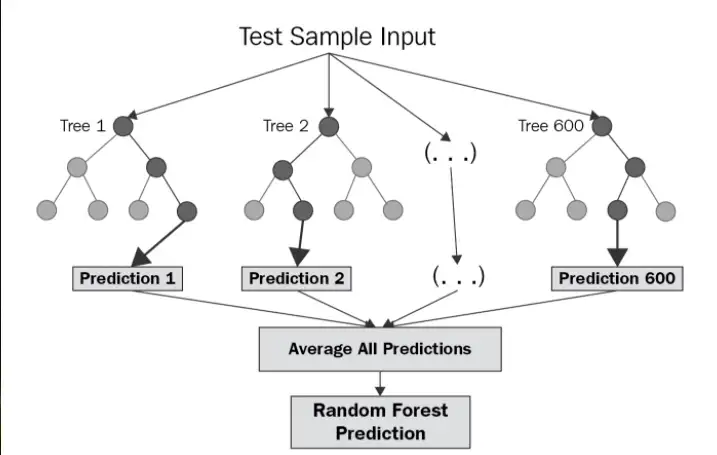
(Picture from https://levelup.gitconnected.com/random-forest-regression-209c0f354c84)

**Hyperparameters**

1. n_estimators: Number of trees
2. max_features
3. max_depth
4. min_samples_split
5. min_samples_leaf
6. criteria


Steps of K-Nearest Neighbours steps:
1. Training the Random Forest Regression model on the training set
2. Test the model
3. Tune the hyperparameters
4. Prediction

Advantages of k-nearest neighbors algorithm:
1. Can be used for both regression and classification
2. Predictions are easy to understand 
3. Efficiently handles large datasets and complicated tasks
4. Higher accuracy in predicting outcomes over the decision tree algorithm.
5. Can automatically balance data sets when a class is more infrequent than other classes
6. Tend not to overfit

Disadvantages of k-nearest neighbors algorithm:
1. High memory storage 
2. High computation cost
3. Slow computational time
4. Sensitive to irrelevant features


Next: Building model and best model parameters 

In [222]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
#from sklearn.ensemble import RandomForestClassifier 
rf_model = RandomForestRegressor(random_state=1)

n_estimators = [50, 100, 200]
max_depth = [5, 8, 15]
min_samples_split = [5, 10, 30, 50, 100]
min_samples_leaf = [1, 2, 5] 

rf_dict = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(rf_model, rf_dict, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train[['sSig_v','sPI']], y_train[['Orig_RES_G']])
best_parameters = bestF.best_params_



Fitting 3 folds for each of 135 candidates, totalling 405 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [223]:
print(best_parameters)

{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 100, 'n_estimators': 200}


In [328]:
optimized_rf = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                      criterion='squared_error', max_depth=5,
                                      max_features='auto',
                                      max_leaf_nodes=None,
                                      max_samples=None,
                                      min_samples_leaf=5,
                                      min_samples_split=100,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=200, n_jobs=None,
                                      oob_score=False, random_state=1,
                                      verbose=0,
                                      warm_start=False)
                                   
optimized_rf.fit(X_train[['sSig_v','sPI']], y_train['Orig_RES_G'])

RandomForestRegressor(max_depth=5, min_samples_leaf=5, min_samples_split=100,
                      n_estimators=200, random_state=1)

Making the prediction, and reversing to the damage classes


In [329]:
y_pred = optimized_rf.predict(X_test[['sSig_v','sPI']])


Testing Data Predictions  

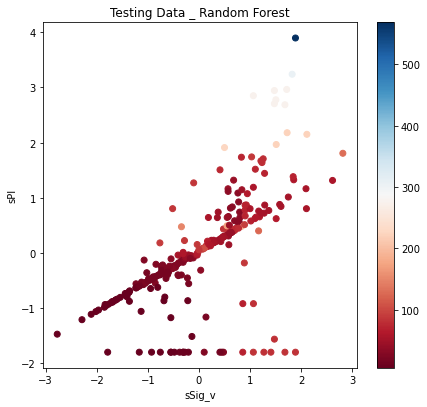

In [336]:
plt.subplot(122)
plt.scatter(X_test['sSig_v'], X_test['sPI'], c=y_pred, 
            cmap='RdBu')
plt.title('Testing Data _ Random Forest'); plt.xlabel('sSig_v'); plt.ylabel('sPI')

plt.colorbar()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2);
plt.show()


Tuned model predictions 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


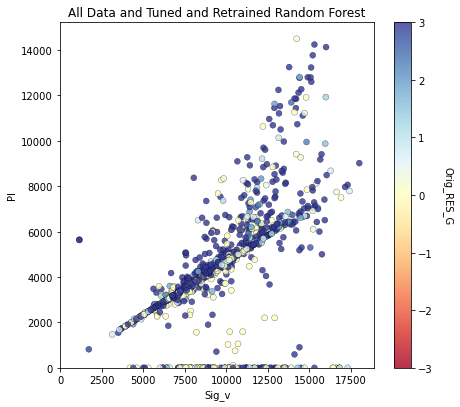

In [337]:
Prediction_RF = optimized_rf.predict(my_data[['sSig_v','sPI']])

plt.subplot(121)
visualize_model(optimized_rf,my_data["Sig_v"],-5,5,my_data["PI"],-3,3,my_data['Orig_RES_G'],-3,3,'All Data and Tuned and Retrained Random Forest')


plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2);
plt.show()


code block from Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_kNearestNeighbour.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_kNearestNeighbour.ipynb).


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Mean Squared Error on Training =  50236.19 , Variance Explained = 0.13
Mean Squared Error on Training =  36842.58 , Variance Explained = -0.03


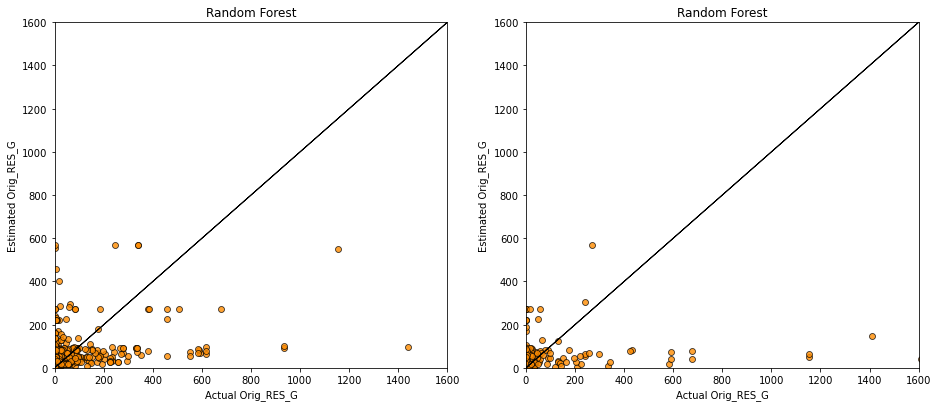

In [338]:
def check_model(model,xfeature,yfeature,response,title):    # plots the estimated vs. the actual  
    predict_train = model.predict(np.c_[xfeature,yfeature])
    plt.scatter(response,predict_train,s=None, c='darkorange',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.8, edgecolors="black")
    plt.title(title); plt.xlabel('Actual Orig_RES_G'); plt.ylabel('Estimated Orig_RES_G')
    plt.xlim(0,1600); plt.ylim(0,1600)
    plt.arrow(0,0,1600,1600,width=0.02,color='black',head_length=0.0,head_width=0.0)
    MSE = metrics.mean_squared_error(response,predict_train)
    Var_Explained = metrics.explained_variance_score(response,predict_train)
    cor = cmath.sqrt(metrics.r2_score(response,predict_train))
    print('Mean Squared Error on Training = ', round(MSE,2),', Variance Explained =', round(Var_Explained,2))

plt.subplot(121)
check_model(optimized_rf,X_train["sSig_v"],X_train["sPI"],y_train["Orig_RES_G"],'Random Forest')

plt.subplot(122)
check_model(optimized_rf,X_test["sSig_v"],X_test["sPI"],y_test["Orig_RES_G"],'Random Forest')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2);
plt.show()

### Simple Demonstration K-nearest Neighbour and Random Forest Regression  Application and Limitations

Below is the summary of the workflow and reslts 

1. Load the data and divide them into training and testing 
 The two top features are Total vertical stress and Pressure, Feature ranking was performed  using Dr. Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_Feature_Ranking.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics__Feature_Ranking.ipynb).

2. Adjusting data range, normalize and standardizing predictor features
 To elemenate the effect of different features scale and feature range and avoid arbitrary feature weighting.

3. K-Nearest Neighbours REgression 
   * Build model using training data
   * test model using testing data 
   * tune model hyperparameters
   * Predictions using tuned model

4. Random Forest Regression
   * Build model using training data
   * test model using testing data 
   * tune model hyperparameters
   * Predictions using tuned model

# Results
#### 1. K-nearest Neighbour
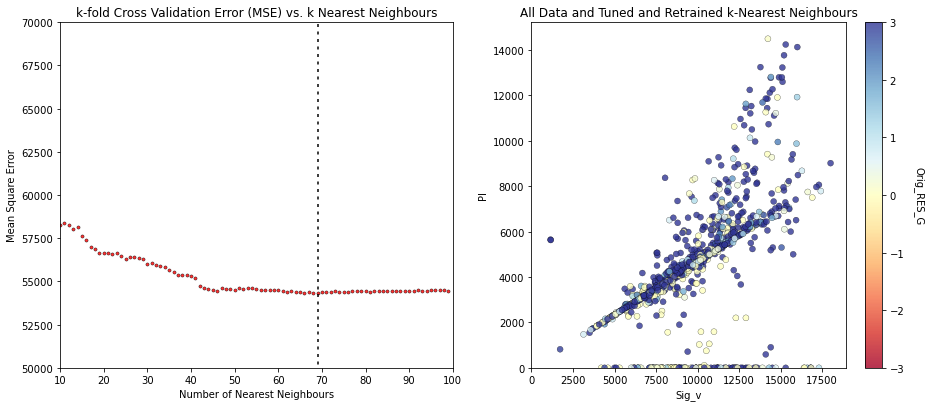
n_neighbors= 70
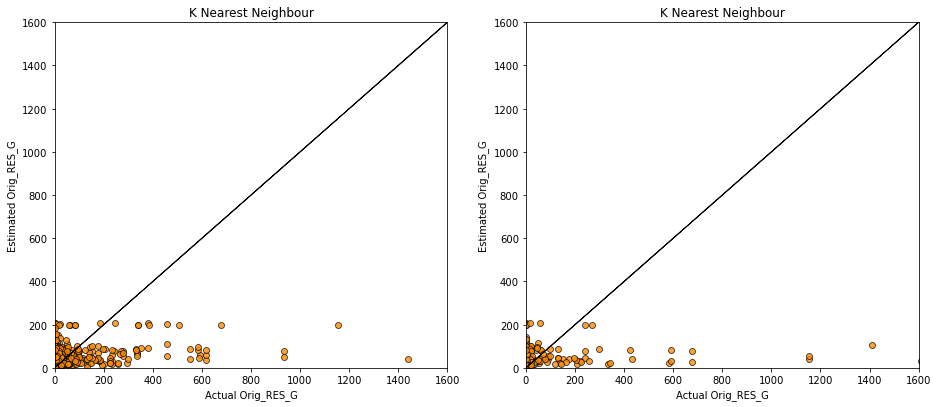
n_neighbors = 10
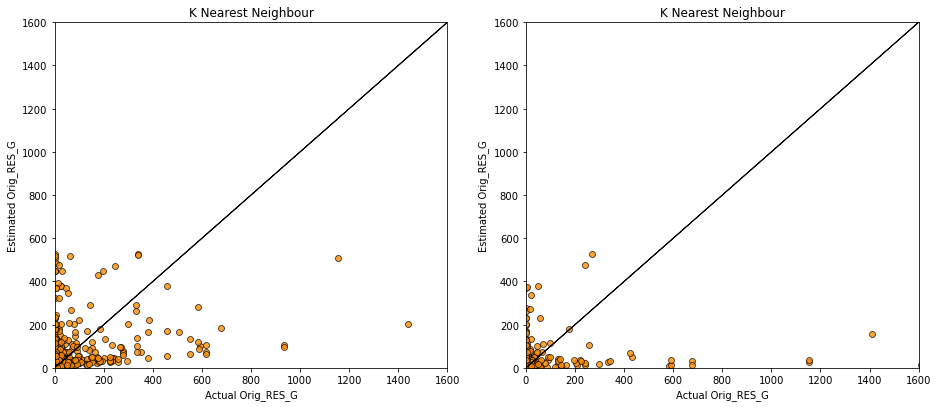
n_neighbors = 5
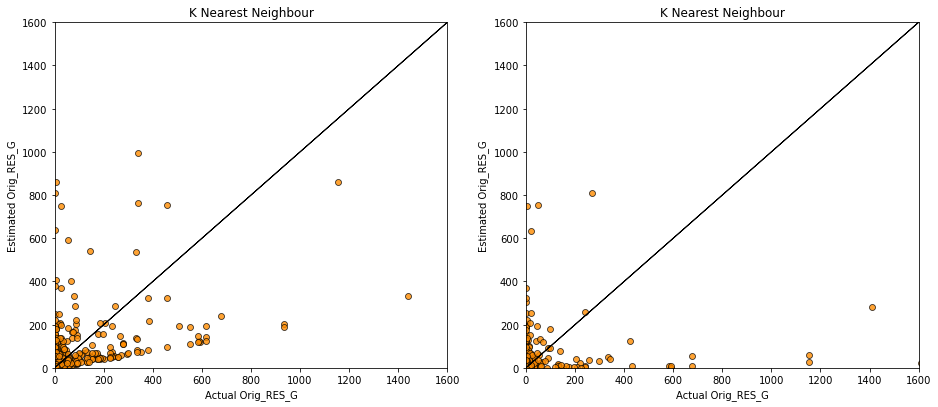
n_neighbors = 2
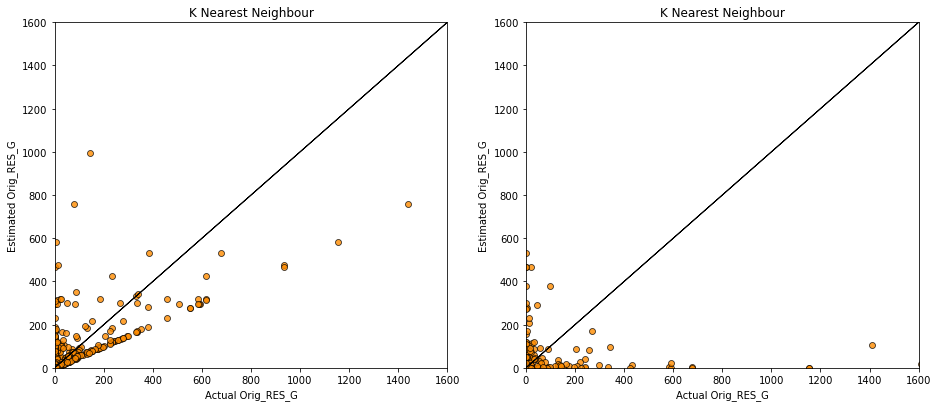
n_neighbors = 1
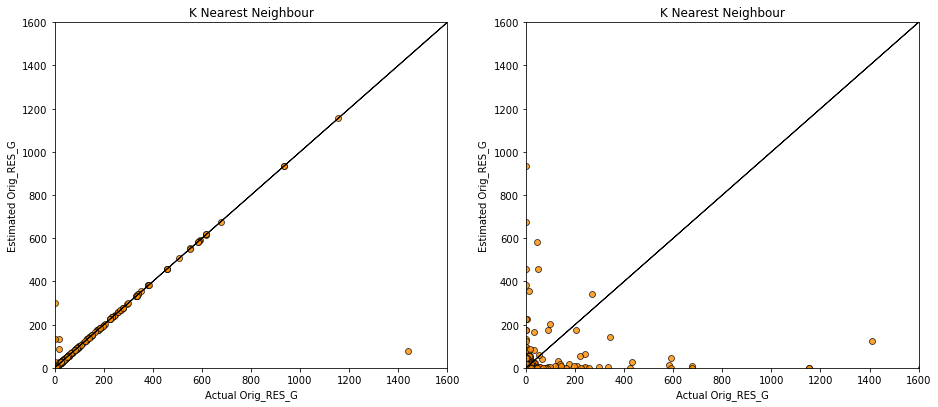


From the previous plot we conclude that were just overfitting the model  because there was no improvement in the testing data prediction 

#### 2. Random Forest Regression 
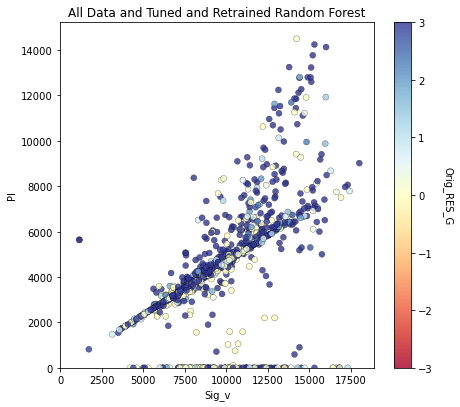

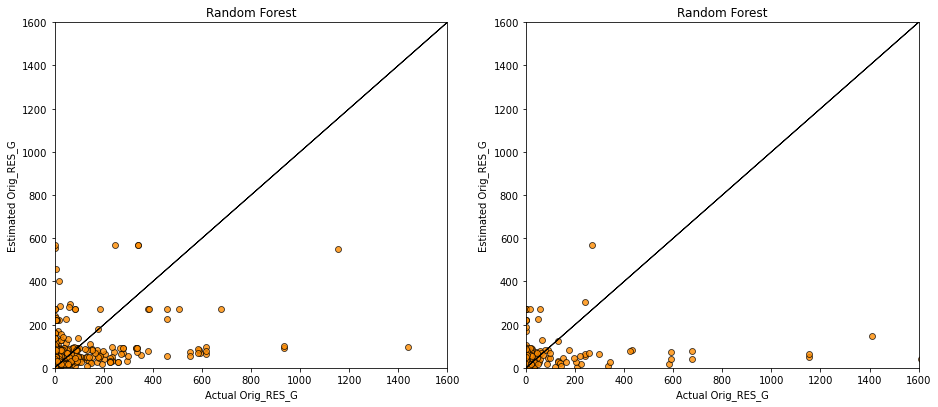

The Random Forest model was more resistant to overfitting during tuning hyperparameters


From the previous summary plots, we can conclude that It was easily ro overfit the K-nearest neighbour while on the other hand, Random forest model was more resistant to over fit. Both methods did not achieve excellent prediction with this data set. This might be for few reasons:
1. the used data set is not a good (used on purpose to test how easy each method will deal with bad data)
2. Using of large data set, requires a lot of computational time and tuning.

The previous results agree with the theory that Random Forest tend not to overfit and can hanndle big and complecated data sets better than k_nearest neighbour. On the other hand, k-nearest neighbour is easier to use, interpret and better in case of small and less complicated data sets


I hope this was helpful,

Mohamed Awad 

___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
